In [6]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim # See https://pytorch.org/docs/stable/optim.html

train_dataset = datasets.CIFAR10(root='./cifar_data/', train=True, transform=transforms.ToTensor(), download=True)
#test_dataset = datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms.ToTensor(), )
train_dataset.data = torch.tensor(train_dataset.data)
#train_dataset.targets = torch.tensor(train_dataset.targets)
#test_dataset.data = torch.tensor(test_dataset.data)
#test_dataset.targets = torch.tensor(test_dataset.targets)

Files already downloaded and verified


torch.Size([32, 32, 3])


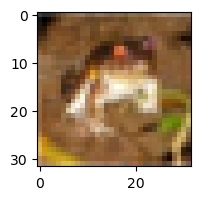

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

image = train_dataset.data[0]
print(image.shape)

plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

In [8]:
from models.model import Unet

bs = 64
ch = 3
size = 32
timestep = 1000
lr = 1e-4
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(ch, size, timestep).to(device)

device

'cuda'

In [9]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm


train_loader = DataLoader(dataset=train_dataset.data, batch_size=bs, shuffle=True)
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
model.train()
samples = []

# noise
sample = model.sampling()
samples.append(sample)

for epoch in range(epochs):
    loader = tqdm(train_loader)
    
    for step, batch in enumerate(loader):
        # (bs, c, h, w) -> (bs, h, w, c)
        batch = batch.permute(0, 3, 1, 2).to(device)
        t = torch.randint(0, timestep-1, (1, ), device=device)
        
        optimizer.zero_grad()
        
        loss = model.get_loss(batch.float(), t)
        
        loss.backward()
        
        optimizer.step()

        loader.set_description(f'Epoch {epoch} | step: {step} | loss: {loss.item():.4f}')
        
    sample = model.sampling()
    samples.append(sample)

Sampling...: 100%|██████████| 1000/1000 [00:12<00:00, 80.05it/s]
Epoch 0 | step: 781 | loss: 1.0048: 100%|██████████| 782/782 [00:12<00:00, 62.47it/s]
Sampling...: 100%|██████████| 1000/1000 [00:11<00:00, 85.19it/s]
Epoch 1 | step: 781 | loss: 0.9383: 100%|██████████| 782/782 [00:12<00:00, 62.87it/s]
Sampling...: 100%|██████████| 1000/1000 [00:12<00:00, 79.23it/s]
Epoch 2 | step: 781 | loss: 0.6922: 100%|██████████| 782/782 [00:11<00:00, 65.75it/s]
Sampling...: 100%|██████████| 1000/1000 [00:12<00:00, 77.34it/s]
Epoch 3 | step: 781 | loss: 0.7316: 100%|██████████| 782/782 [00:12<00:00, 63.88it/s]
Sampling...: 100%|██████████| 1000/1000 [00:13<00:00, 76.55it/s]
Epoch 4 | step: 781 | loss: 0.7745: 100%|██████████| 782/782 [00:11<00:00, 65.59it/s]
Sampling...: 100%|██████████| 1000/1000 [00:13<00:00, 75.95it/s]


Sampling...: 100%|██████████| 1000/1000 [00:02<00:00, 401.66it/s]


torch.Size([3, 32, 32])


TypeError: Invalid shape (3, 32, 32) for image data

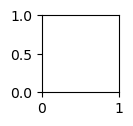

In [ ]:
model.eval()

with torch.no_grad():
    image = model.sampling()
    image = image.squeeze(0).cpu()
    image = image.permute(1, 2, 0)

    print(image.shape)
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.show()

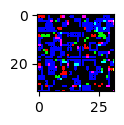

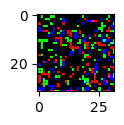

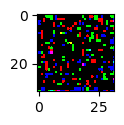

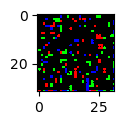

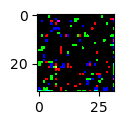

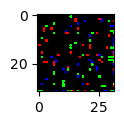

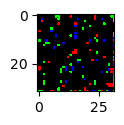

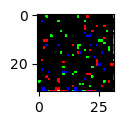

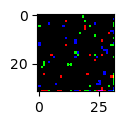

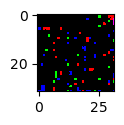

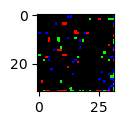

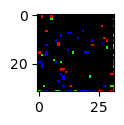

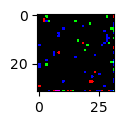

In [ ]:
with torch.no_grad():
    for image in samples:
        image = image.squeeze(0).cpu()
        image = image.permute(1, 2, 0)
        
        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.show()